In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm

## 1. SETUP

In [26]:
TRAIN_DATA_PATH = Path("data/train")
TEST_DATA_PATH = Path("data/test")

def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

## 2. DATASET

In [27]:
class RootVolumeImageDataset(Dataset):
    def __init__(self, df, base_path, is_train=True, img_size=128):
        self.df = df
        self.base_path = base_path
        self.is_train = is_train
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])


    def load_side(self, folder, side):
        images = []
        for i in range(1, 22):  # slices 001–021
            img_path = self.base_path / folder / f"{folder}_{side}_{i:03d}.png"

            # If file missing or unreadable, substitute zeros:
            if not img_path.is_file():
                img = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
            else:
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    img = np.zeros((self.img_size, self.img_size), dtype=np.uint8)

            images.append(self.transform(img))  # shape (1, H, W)

        return torch.stack(images) 


    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        left_imgs = self.load_side(row["FolderName"], "L")
        right_imgs = self.load_side(row["FolderName"], "R")

        # squeeze channel dim if needed
        if left_imgs.shape[1] == 1:
            left_imgs = left_imgs.squeeze(1)  # (21, H, W)
        if right_imgs.shape[1] == 1:
            right_imgs = right_imgs.squeeze(1)  # (21, H, W)

        combined = torch.stack([left_imgs, right_imgs])  # (2, 21, H, W)

        if self.is_train:
            label = row["RootVolume"]
            return combined, torch.tensor(label, dtype=torch.float32)
        else:
            return combined

    def __len__(self):
        return len(self.df)

## 3. MODEL

In [ ]:
class RootVolumeCNNLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # output: (batch*21, 32, 1, 1)
        )
        self.lstm = nn.LSTM(32, 64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64 * 2, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):  # x shape: (batch, 2, 21, H, W)
        batch = x.size(0)
        side_outputs = []

        for s in range(2):
            side = x[:, s]  # (batch, 21, H, W)
            side = side.reshape(batch * 21, 1, side.size(2), side.size(3))  # safe reshape
            feats = self.cnn(side).view(batch, 21, -1)  # (batch, 21, 32)
            lstm_out, _ = self.lstm(feats)  # (batch, 21, 64)
            side_outputs.append(lstm_out[:, -1, :])  # take last timestep

        combined = torch.cat(side_outputs, dim=1)  # (batch, 128)
        return self.fc(combined).squeeze(1)  

## 4. MAIN LOOP

Loading data...
Creating datasets...
Using device: cpu
Epoch [1/100], Train Loss: 3.9780, Val Loss: 1.8634, Val RMSE: 1.3722
Epoch [2/100], Train Loss: 2.4756, Val Loss: 2.2287, Val RMSE: 1.4941
Epoch [3/100], Train Loss: 2.5605, Val Loss: 2.0012, Val RMSE: 1.4173
Epoch [4/100], Train Loss: 2.4770, Val Loss: 1.9758, Val RMSE: 1.4086
Epoch [5/100], Train Loss: 2.4681, Val Loss: 1.9366, Val RMSE: 1.3997
Epoch [6/100], Train Loss: 2.5970, Val Loss: 1.8337, Val RMSE: 1.3593
Epoch [7/100], Train Loss: 2.4462, Val Loss: 1.8265, Val RMSE: 1.3576
Epoch [8/100], Train Loss: 2.4936, Val Loss: 2.0275, Val RMSE: 1.4264
Epoch [9/100], Train Loss: 2.4638, Val Loss: 1.8263, Val RMSE: 1.3570
Epoch [10/100], Train Loss: 2.4655, Val Loss: 1.9033, Val RMSE: 1.3833
Epoch [11/100], Train Loss: 2.4988, Val Loss: 1.8248, Val RMSE: 1.3567
Epoch [12/100], Train Loss: 2.4840, Val Loss: 1.9142, Val RMSE: 1.3871
Epoch [13/100], Train Loss: 2.4596, Val Loss: 1.8244, Val RMSE: 1.3566
Epoch [14/100], Train Loss: 2.4

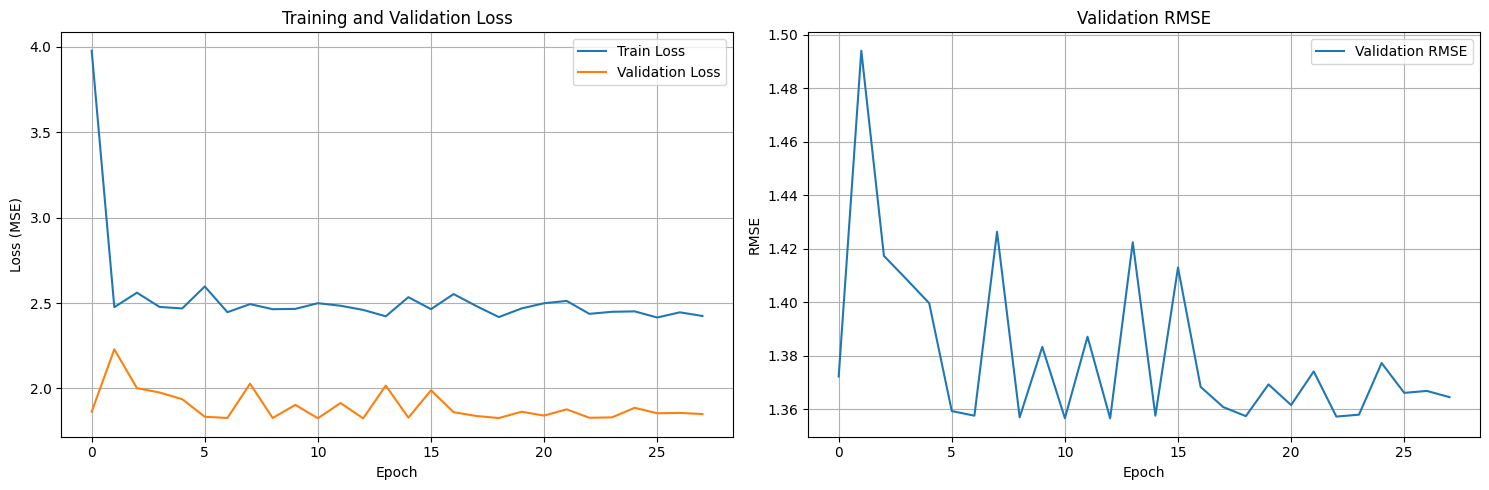

In [29]:
def main():
    print("Loading data...")
    train_df = pd.read_csv("Train.csv")
    test_df = pd.read_csv("Test.csv")
    submission_df = pd.read_csv("Sample_Submission.csv")

    print("Creating datasets...")
    train_dataset = RootVolumeImageDataset(train_df, TRAIN_DATA_PATH, is_train=True)
    test_dataset = RootVolumeImageDataset(test_df, TEST_DATA_PATH, is_train=False)

    train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=8, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = RootVolumeCNNLSTM().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    num_epochs = 100
    best_loss = float('inf')
    early_stop_patience = 15
    no_improve_count = 0

    history = {'train_loss': [], 'val_loss': [], 'val_rmse': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for imgs, targets in train_dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        history['train_loss'].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for imgs, targets in val_dataloader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        val_loss /= len(val_dataloader)
        val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        history['val_loss'].append(val_loss)
        history['val_rmse'].append(val_rmse)

        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'Root_model.pt')
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['val_rmse'], label='Validation RMSE')
    plt.title('Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    print("Training history plot saved to 'training_history.png'")

    # Make predictions on test set
    print("Making predictions on test set...")
    checkpoint=torch.load('Root_model.pt',weights_only=True)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    model.eval()

    test_preds = []

    with torch.no_grad():
        for imgs in test_dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            test_preds.extend(outputs.cpu().numpy())

    submission = test_df[['ID']].copy()
    submission['RootVolume'] = test_preds
    submission.to_csv('submission.csv', index=False)
    print("Submission file created!")
    print(submission.head())

if __name__ == "__main__":
    main()
